In [230]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.offline import  init_notebook_mode,iplot
init_notebook_mode(connected=True)
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/world-university-rankings/school_and_country_table.csv
/kaggle/input/world-university-rankings/cwurData.csv
/kaggle/input/world-university-rankings/education_expenditure_supplementary_data.csv
/kaggle/input/world-university-rankings/timesData.csv
/kaggle/input/world-university-rankings/educational_attainment_supplementary_data.csv
/kaggle/input/world-university-rankings/shanghaiData.csv


In [231]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [232]:
data_waktu = pd.read_csv('/kaggle/input/world-university-rankings/timesData.csv')

data_waktu.head(5)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011


In [233]:
data_waktu.shape

(2603, 14)

In [234]:
data_waktu.dtypes

world_rank                 object
university_name            object
country                    object
teaching                  float64
international              object
research                  float64
citations                 float64
income                     object
total_score                object
num_students               object
student_staff_ratio       float64
international_students     object
female_male_ratio          object
year                        int64
dtype: object

In [235]:
data_waktu.isna().any()

world_rank                False
university_name           False
country                   False
teaching                  False
international             False
research                  False
citations                 False
income                    False
total_score               False
num_students               True
student_staff_ratio        True
international_students     True
female_male_ratio          True
year                      False
dtype: bool

In [236]:
data_waktu['num_students'].isna().sum() #mengetahui apakah ada yang missing

59

In [237]:
data_waktu['student_staff_ratio'].isna().sum()

59

In [238]:
data_waktu['international_students'].isna().sum()

67

In [239]:
data_waktu['female_male_ratio'].isna().sum()

233

In [285]:
data_waktu.nunique()

world_rank                250
university_name           818
country                    72
teaching                  666
international             804
research                  740
citations                 848
income                    613
total_score               415
num_students              794
student_staff_ratio       308
international_students     53
female_male_ratio          69
year                        6
dtype: int64

In [286]:
data_waktu.year.unique()

array([2011, 2012, 2013, 2014, 2015, 2016])

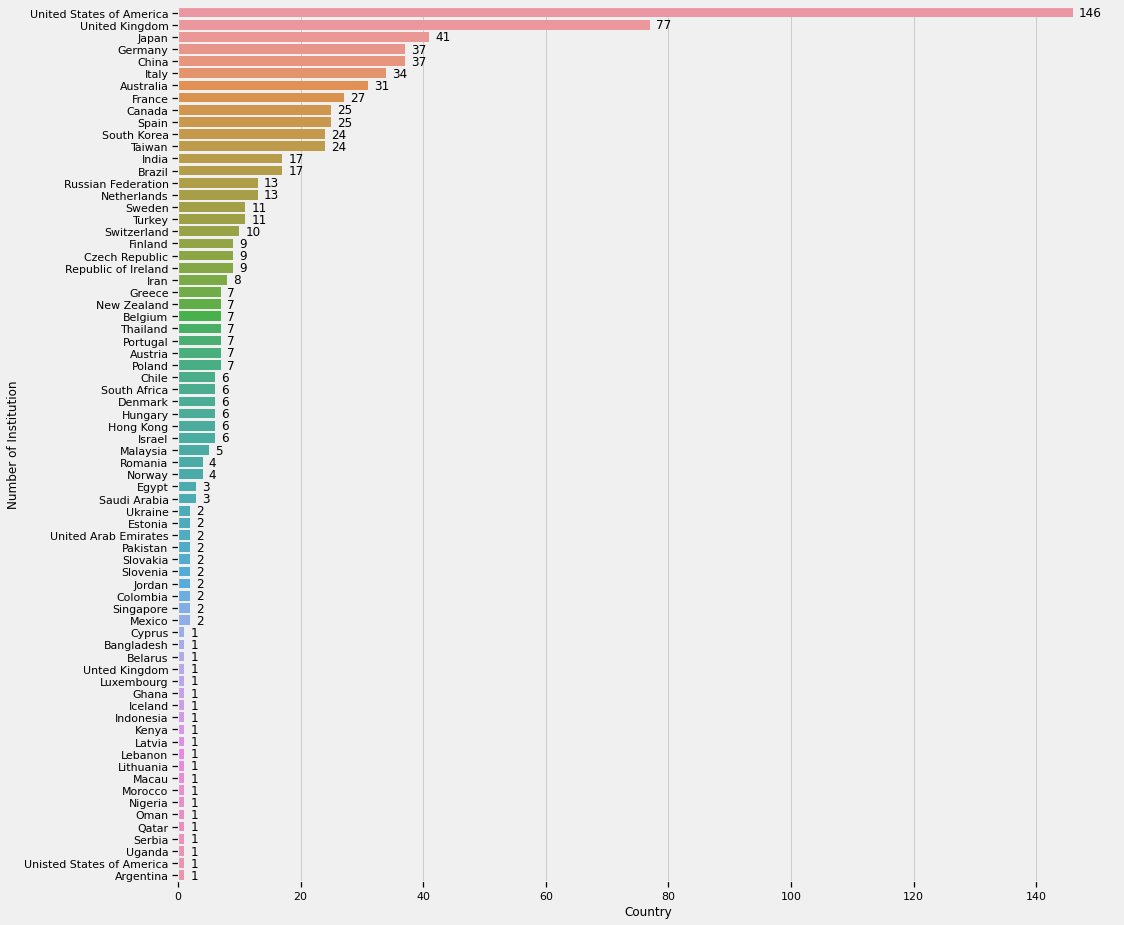

In [288]:
ins_count = data_waktu[data_waktu['year'] == 2016].groupby('country').size().sort_values(ascending = False)
plt.figure(figsize = (15,15))
ax = sns.barplot(x = ins_count.values, y = ins_count.index)
ax.set(xlabel = 'Country', ylabel = 'Number of Institution')
for i in ax.patches:
    ax.text(i.get_width()+1.0, i.get_y()+0.7,i.get_width().astype(int))
plt.show()

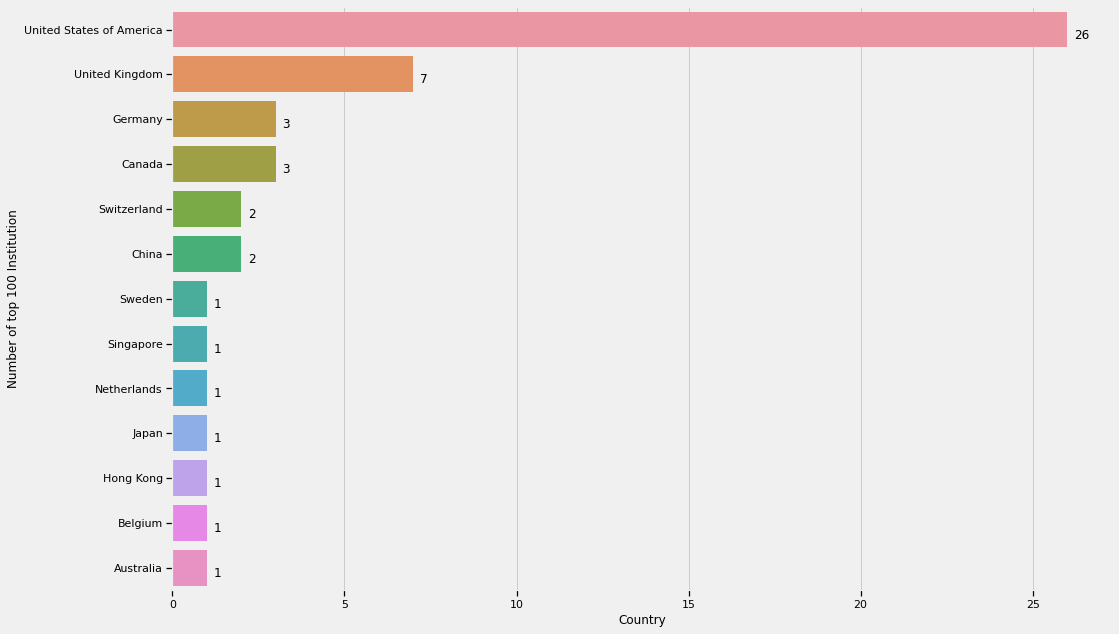

In [289]:
top_count = data_waktu[data_waktu['year'] == 2016].head(50).groupby('country').size().sort_values(ascending = False)
plt.figure(figsize = (15,10))
ax = sns.barplot(x = top_count.values, y = top_count.index)
ax.set(xlabel = 'Country', ylabel = 'Number of top 100 Institution')
for i in ax.patches:
    ax.text(i.get_width()+0.2, i.get_y()+0.6,i.get_width().astype(int))
plt.show()

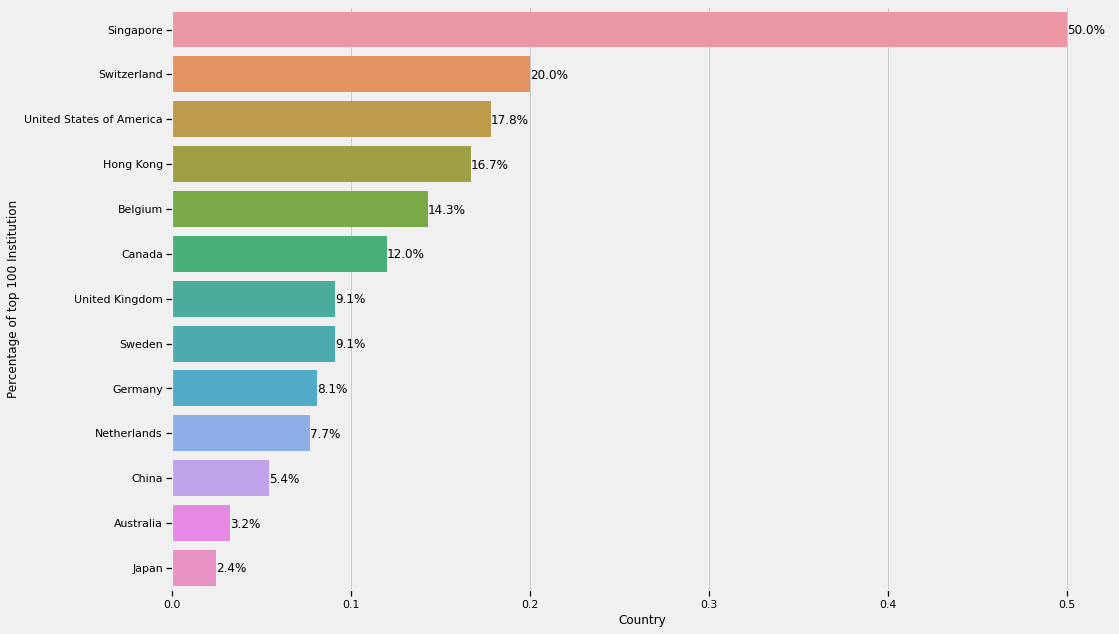

In [290]:
per_count = top_count/ins_count
per_count.dropna(inplace = True)
per_count.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (15,10))
ax = sns.barplot(x = per_count.values, y = per_count.index)
ax.set(xlabel = 'Country', ylabel = 'Percentage of top 100 Institution')
for i in ax.patches:
    ax.text(i.get_width(), i.get_y()+0.5,str(round(i.get_width()*100,1))+'%')
plt.show()

In [291]:
university_name = list(data_waktu.university_name.unique())
non_decreasing = pd.DataFrame(data=university_name,columns=['university_name'])
non_decreasing.head()

,university_name
0,Harvard University
1,California Institute of Technology
2,Massachusetts Institute of Technology
3,Stanford University
4,Princeton University


In [293]:
def non_decreasing_rank(university_name):
    world_rank = list(data_waktu[data_waktu.university_name == university_name]['world_rank'])
    count = data_waktu.groupby('university_name').size()[university_name]
    for i in range(1,count): #1,2,3
        if world_rank[i-1] < world_rank[i]:
            return False
    return True

#Moment of truth
non_decreasing[non_decreasing['university_name'].apply(non_decreasing_rank) == True]

,university_name
1,California Institute of Technology
45,University of Wisconsin
47,École Polytechnique Fédérale de Lausanne
59,New York University
233,Ulm University
...,...
813,Xidian University
814,Yeungnam University
815,Yıldız Technical University
816,Yokohama City University


In [297]:
data_waktu2016 = data_waktu[data_waktu.year == 2015]
data_waktu2016.drop(['country','year'],axis = 1, inplace = True)
data_waktu2016.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,world_rank,university_name,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio
1402,1,California Institute of Technology,92.2,67.0,98.1,99.7,89.1,94.3,"2,243",6.9,27%,33 : 67
1403,2,Harvard University,92.9,67.6,98.6,98.9,44.0,93.3,"20,152",8.9,25%,NaN
1404,3,University of Oxford,88.6,90.7,97.7,95.5,72.9,93.2,"19,919",11.6,34%,46 : 54
1405,4,Stanford University,91.5,69.0,96.7,99.1,63.1,92.9,"15,596",7.8,22%,42 : 58
1406,5,University of Cambridge,89.7,87.8,95.6,95.2,51.1,92.0,"18,812",11.8,34%,46 : 54


In [298]:
data_waktu2016.isnull().sum()

world_rank                 0
university_name            0
teaching                   0
international              0
research                   0
citations                  0
income                     0
total_score                0
num_students              11
student_staff_ratio       11
international_students    12
female_male_ratio         38
dtype: int64

In [299]:
data_waktu2016.fillna(method='ffill', inplace= True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
data_waktu2016.isnull().sum()

world_rank                0
university_name           0
teaching                  0
international             0
research                  0
citations                 0
income                    0
total_score               0
num_students              0
student_staff_ratio       0
international_students    0
female_male_ratio         0
dtype: int64

In [301]:
data_waktu2016.isin(['-']).sum()

world_rank                  0
university_name             0
teaching                    0
international               0
research                    0
citations                   0
income                     20
total_score               200
num_students                0
student_staff_ratio         0
international_students      0
female_male_ratio           0
dtype: int64

In [302]:
data_waktu2016 = data_waktu2016[(~data_waktu2016['total_score'].isin(['-']))&(~data_waktu2016['income'].isin(['-']))]
data_waktu2016.isin(['-']).sum()

world_rank                0
university_name           0
teaching                  0
international             0
research                  0
citations                 0
income                    0
total_score               0
num_students              0
student_staff_ratio       0
international_students    0
female_male_ratio         0
dtype: int64

In [307]:
col = list(data_waktu2016.columns.values)

for i in range(2,8):
    data_waktu2016[col[i]] = pd.to_numeric(data_waktu2016[col[i]])

In [308]:
data_waktu2016.shape

(188, 12)

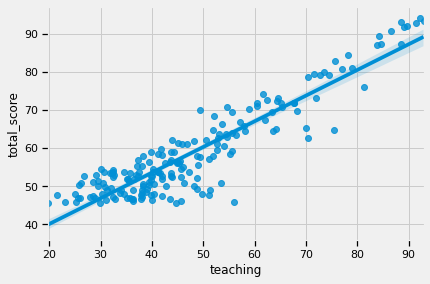

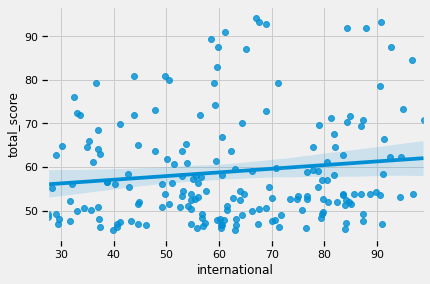

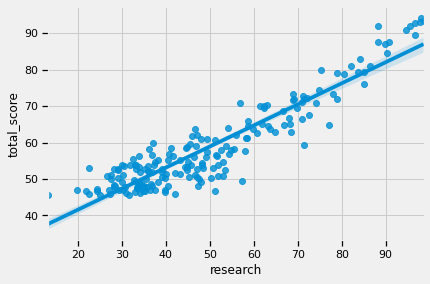

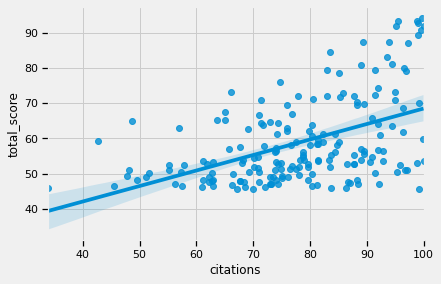

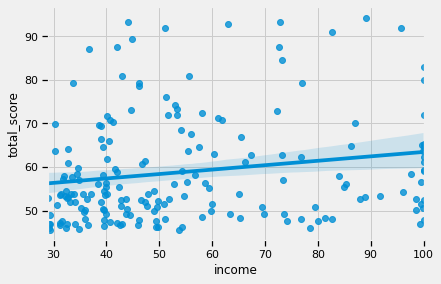

In [309]:
factor = col[2:7]
for i in range(len(factor)):
    z = data_waktu2016[factor[i]]
    plt.figure(i)
    sns.regplot(x=z, y='total_score', data = data_waktu2016)

In [310]:
cor = pd.DataFrame()
for i in range(len(factor)):
    cor[factor[i]] = data_waktu2016[factor[i]]
cor['total_score'] = data_waktu2016.total_score
cor.corr() 

,teaching,international,research,citations,income,total_score
teaching,1.000000,-0.053589,0.917052,0.193439,0.225508,0.915469
international,-0.053589,1.000000,0.039631,0.056968,-0.036396,0.130251
research,0.917052,0.039631,1.000000,0.164893,0.258663,0.924404
citations,0.193439,0.056968,0.164893,1.000000,-0.219629,0.484386
income,0.225508,-0.036396,0.258663,-0.219629,1.000000,0.184958
total_score,0.915469,0.130251,0.924404,0.484386,0.184958,1.000000


In [318]:
score = data_waktu2016.total_score
train = data_waktu2016[factor] 
lab_enc = preprocessing.LabelEncoder()
score_encoded = lab_enc.fit_transform(score)

In [314]:
x_train, y_train, x_test, y_test = train_test_split(train,score_encoded,train_size = 0.9, random_state = 0)

In [315]:
#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(x_train,x_test)
y_pred = tree.predict(y_train)
y1 = lab_enc.inverse_transform(y_test)
y2 = lab_enc.inverse_transform(y_pred)

[[1.         0.98168255]
 [0.98168255 1.        ]]


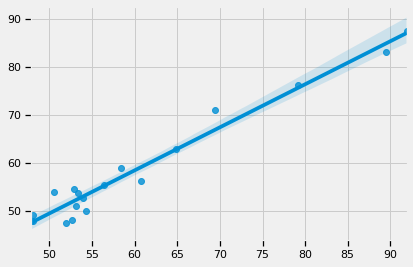

In [316]:
print(np.corrcoef(y1,y2))
sns.regplot(y1,y2)

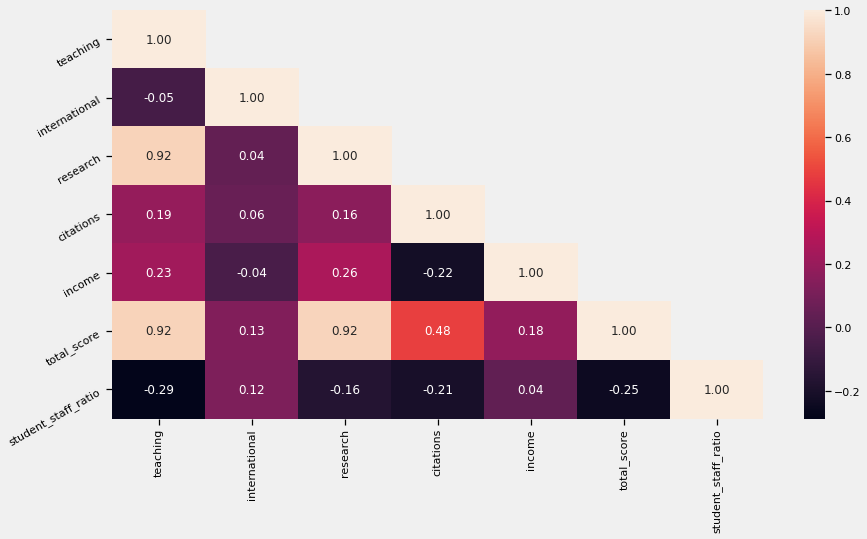

In [317]:
corr =data_waktu2016.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

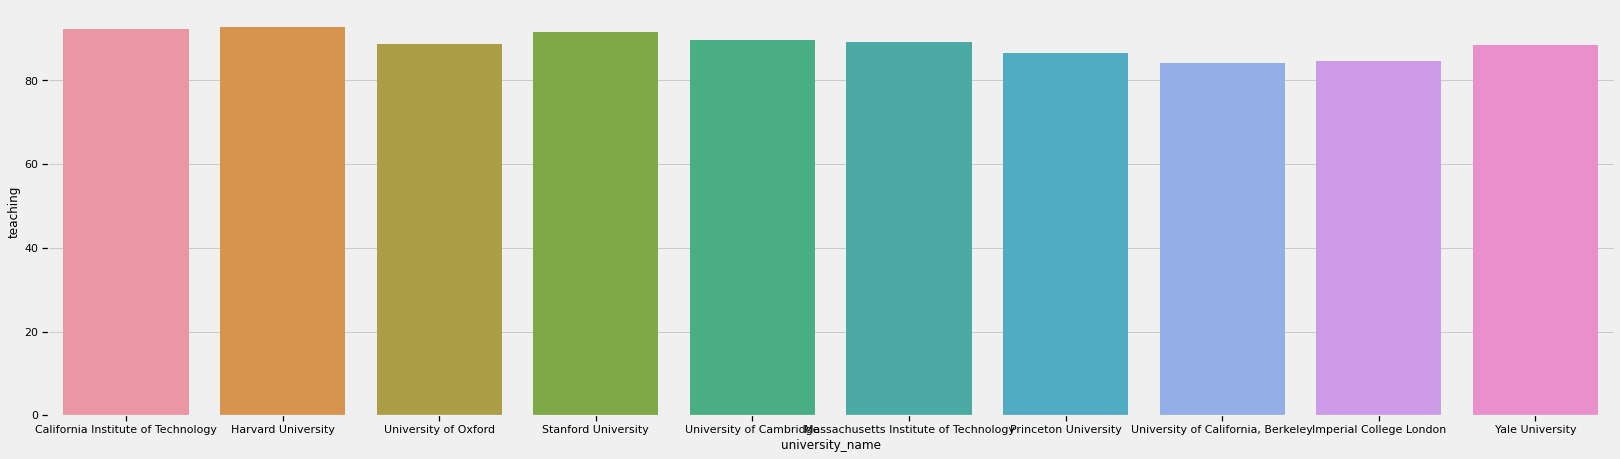

In [322]:
plt.figure(figsize=(25,7)) # this creates a figure 20 inch wide, 7 inch high
sns.barplot(datawaktu2016_baru['university_name'], datawaktu2016_baru['teaching'])

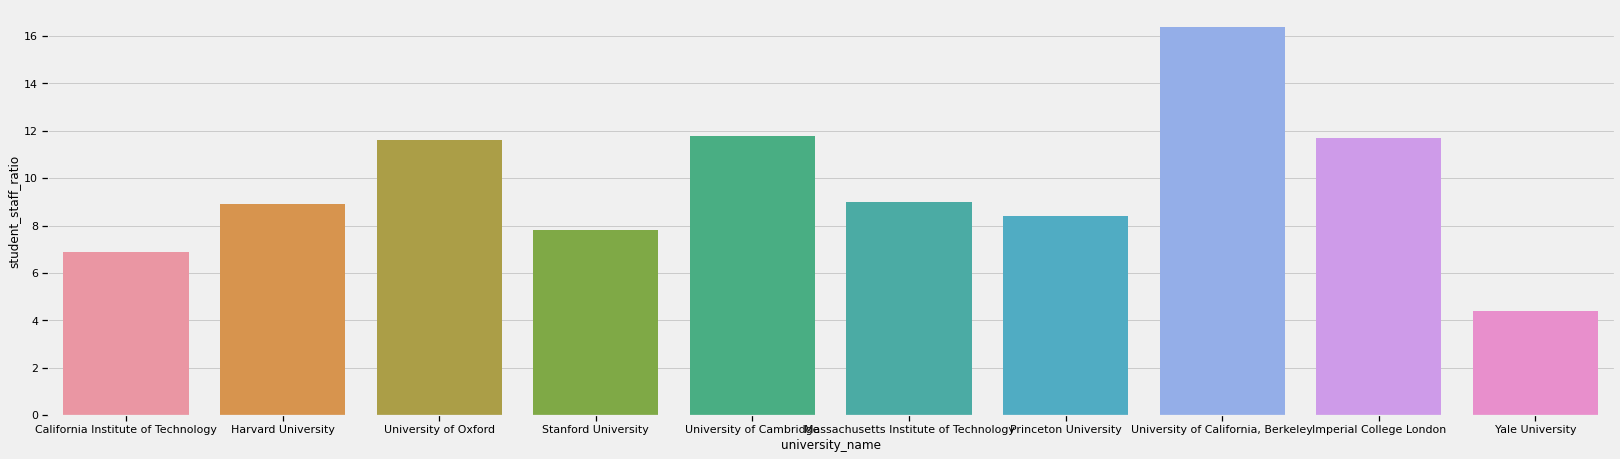

In [323]:
plt.figure(figsize=(25,7)) # this creates a figure 20 inch wide, 7 inch high
sns.barplot(datawaktu2016_baru['university_name'], datawaktu2016_baru['student_staff_ratio'])